# Aujourd'hui on roule sur les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [33]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [34]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [35]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [36]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [37]:
def load_data(file,data_path=DATA_PROCESSED, sep=';'):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep=';')

# On load les jeux de données

In [38]:
TX_data = load_data(file = "train.csv");

In [39]:
TX_data.info() # 42 colonnes, c'est un nombre qui fait plaisir. [Note, il y en a plus maintenant, mais ce commentaire me fait toujours rire]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 65 columns):
SHIPPING_MODE                 100000 non-null object
SHIPPING_PRICE                100000 non-null int64
WARRANTIES_FLG                100000 non-null bool
WARRANTIES_PRICE              100000 non-null int64
CARD_PAYMENT                  100000 non-null int64
COUPON_PAYMENT                100000 non-null int64
RSP_PAYMENT                   100000 non-null int64
WALLET_PAYMENT                100000 non-null int64
PRICECLUB_STATUS              100000 non-null int64
REGISTRATION_DATE             100000 non-null int64
PURCHASE_COUNT                100000 non-null int64
BUYER_BIRTHDAY_DATE           100000 non-null float64
BUYER_DEPARTMENT              100000 non-null int64
BUYING_DATE                   100000 non-null int64
SELLER_SCORE_COUNT            100000 non-null int64
SELLER_SCORE_AVERAGE          100000 non-null float64
SELLER_COUNTRY                100000 non-null object
S

### Split entre train et test

In [40]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )
del TX_data;

# Jointure entre les X et Y

In [41]:
from sklearn.preprocessing import Imputer

def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    try :
        Y=data["CLAIM_TYPE"]
        X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    except:
        Y=0
        X=data
    # Exclude Objets
    X=X.select_dtypes(exclude=['object']) # j'exclude les variables catégorielles que j'ai oublié
    
    # Work on fare
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [42]:
X_train, Y_train = datapreprocess(train_set)
X_test, Y_test = datapreprocess(test_set)

gc.collect()

4519

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(truth, pred):
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [44]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

# MODEL!

In [45]:
from sklearn.utils.class_weight import compute_sample_weight

In [46]:
sample_weight_arr = compute_sample_weight(class_weight='balanced', y=Y_train)

## XGBoost

#### Core XGBoost Library VS scikit-learn API

Models can be trained in two different ways:

1. Directly using the core library – this is closer to the implementation of the caret-package in R
2. Using the scikit-learn API – this means that the models are implemented in a way that lets the scikit package recognize it as one of it’s own models.

Nous, on va travailler avec l'API de Sklearn, c'est pas optimisé mais plus simple. De toute façon, j'arrive pas à utiliser le Core, a cause des DMatrix qui veulent que des numerics en entrées

Doc des paramètres: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

Doc sur le tunning : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [47]:
from xgboost import XGBClassifier

###  XGBoost solo

In [73]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    'nthread':4,
    'n_estimators' : 500,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.02,
    'min_child_weight' : 1, #A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
    'max_depth' : 4,
    #'max_leaf_nodes':None, #If this is defined, GBM will ignore max_depth.
    'gamma' : 0.4,
    'max_delta_step':1, #it might help in logistic regression when class is extremely imbalanced/ 1-10 might help control the update
    'subsample' : 0.8,
    'colsample_bytree' : 0.9,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'reg_alpha':0.05,
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    #'objective' : ['rank:pairwise','multi:softmax'], # you also need to set an additional num_class (number of classes)
    'objective' :['reg:gamma', 'rank:pairwise','multi:softmax'],
    'num_class' : len(Y_train.unique()),
    'eval_metric':["mlogloss", 'auc'],
    'seed' : RANDOM_SEED,
    'random_state':RANDOM_SEED
}

'base_score':0.5,
'booster':'gbtree',
'colsample_bylevel':1,
'colsample_bytree':0.8,
'eval_metric':'auc',
'gamma':0.3,
'learning_rate':0.09,
'max_delta_step':1,
'max_depth':2,
'min_child_weight':1,
'missing':None,
'n_estimators':100,
'n_jobs':1,
'nthread':None,
'num_class':8,
'objective':'multi:softprob',
'random_state':0,
'reg_alpha':0,
'reg_lambda':1,
'seed':42,
'silent':0,
'subsample':0.7

In [74]:
xgb_clf = XGBClassifier(**params_XGB)

In [75]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

In [76]:
params_XGB_fit={
    'X':X_train, 
    'y':Y_train, 
    'sample_weight':sample_weight_arr, 
    'eval_set':None, 
    'eval_metric':["mlogloss", 'auc'], 
    'early_stopping_rounds':None, 
    'verbose':False, 
    'xgb_model':None
}

In [77]:
xgb_clf.fit(**params_XGB_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, eval_metric=['mlogloss', 'auc'], gamma=0.4,
       learning_rate=0.02, max_delta_step=4, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=4, num_class=8, objective='multi:softprob', random_state=42,
       reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=array([0.90695, 1.7854 , ..., 3.07409, 0.25012]),
       seed=42, silent=0, subsample=0.8)

In [78]:
y_pred_xgb_train = xgb_clf.predict(X_train)
y_pred_xgb = xgb_clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [79]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_xgb_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_xgb)

In [80]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))

Performance sur le train : 0.6361132833931927
Performance sur le test : 0.6223442846950169


Performance sur le train : 0.7066348172305776

Performance sur le test : 0.6256314390125582

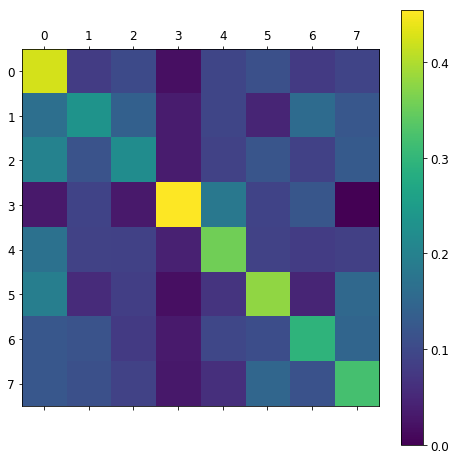

In [64]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

#### C'est un beau score pour le XBoost

Cependant, j'ai optimisé pour la mauvaise métrique, et j'ai toujours pas fait le Grid Search

In [32]:
pd.DataFrame(xgb_clf.feature_importances_, index=X_train.columns, columns=["Feature"]).sort_values(by="Feature", ascending=False)

,Feature
Mean_Claims_Sells_ID,0.083991
Count_Sells_ID,0.063824
STD_Claims_Sells_ID,0.054981
SELLER_SCORE_AVERAGE,0.046013
BUYER_BIRTHDAY_DATE,0.045455
Mean_Claims_PRODUCT_TYPE,0.040728
Count_PRODUCT_TYPE,0.035965
BUYING_DATE,0.035210
STD_Claims_PRODUCT_TYPE,0.031957
ITEM_PRICE,0.031526


### XGBoost Grid Search Iterate

Comme mon PC est pourri, je vais chercher les paramètres de façon iterative

In [16]:
from sklearn.model_selection import GridSearchCV

#### Paramètres pour le XGB qui ne changent pas

In [ ]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    'nthread':4, # Je vais le commenter, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 100,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.09,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax',
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
    'random_state':RANDOM_SEED
}

#### Paramètres pour la méthode `fit` de XGB qui ne changent pas

In [17]:
fit_params_xgb_cv={
    'sample_weight': sample_weight_arr, 
    'eval_set' : None, 
    'eval_metric' : 'auc', 
    'early_stopping_rounds' : None, 
    'verbose':False, 
    'xgb_model':None
}

###  Optim 1 : max_depth, min_child_weight et max_delta_step

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'max_depth':range(2,5),
    'min_child_weight':range(1,6),
    'max_delta_step':list(range(1,5)),
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `max_depth` : `4`
2. `min_child_weight` : `5`
3. `max_delta_step` : `4`

###  Optim 2 : gamma, et subsample

In [ ]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    'nthread':4, # Je vais le commenter, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 100,
    'max_depth' : 4,
    'min_child_weight' : 5,
    'max_delta_step' : 4,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.09,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax',
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
    'random_state':RANDOM_SEED
}

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `gamma` : `0.4`
2. `subsample` : `0.8`

###  Optim 3 : colsample_bytree, et reg_alpha

In [ ]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    'nthread':4, # Je vais le commenter, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 100,
    'max_depth' : 4,
    'min_child_weight' : 5,
    'max_delta_step' : 4,
    'subsample' : 0.8,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.09,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'scale_pos_weight' : sample_weight_arr,
    'gamma' : 0.4,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax',
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
    'random_state':RANDOM_SEED
}

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `colsample_bytree` : `0.9`
2. `reg_alpha` : `0.05`

###  Optim 4 : Le Learning rate 

Objectif : faire diminuer le risque d'overfit'

In [18]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    'nthread':4, # Je le commente, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 100,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    #'learning_rate' : 0.09,
    'min_child_weight' : 5, #A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
    'max_depth' : 4,
    #'max_leaf_nodes':None, #If this is defined, GBM will ignore max_depth.
    'gamma' : 0.4,
    'max_delta_step':4, #it might help in logistic regression when class is extremely imbalanced/ 1-10 might help control the update
    'subsample' : 0.8,
    'colsample_bytree' : 0.9,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'reg_alpha':0.05,
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax', # you also need to set an additional num_class (number of classes)
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
    'random_state':RANDOM_SEED
}

In [19]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'learning_rate':[i/1000.0 for i in range(3,22)],
}

In [20]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [21]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed: 66.5min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, eval_metric='auc', gamma=0.4,
       learning_rate=0.02, max_delta_step=4, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=4, num_class=8, objective='multi:softprob', random_state=42,
       reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=array([0.90695, 1.7854 , ..., 3.07409, 0.25012]),
       seed=42, silent=0, subsample=0.8)
ROC score : 0.6119559059632669


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###  Optim 5 : L'ensemble des paramètres trouvés

L'idée ici est de vérifier si les paramètres, ensemble, fonctionnent bien, donc on prend les paramètres trouvés, et on cherche un peu à gauche et à droite de chacun

In [ ]:
params_XGB={
    #'base_score':0.5,
    'booster':'gbtree',
    'eval_metric':'auc',
    'learning_rate':0.09,
    'missing':None,
    'n_estimators':100,
    'n_jobs':4,
    'nthread':4,
    'num_class':8,
    'objective':'multi:softmax',
    'random_state':RANDOM_SEED,
    'reg_lambda':1,
    'seed':RANDOM_SEED,
    'silent':0,
    
    'reg_alpha' : 0.05
    
}

In [ ]:
params_XGB_CV={
    'colsample_bylevel':[1, 2], #
    'colsample_bytree':[0.8, 0.9, 1.0], #
    'gamma':[0.3, 0.4, 0.4], #
    'max_delta_step':[3,4], #
    'max_depth':[3,4], #
    'min_child_weight':[4,5], #
    'subsample':[0.6,0.7,0.8] #
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)